<a href="https://colab.research.google.com/github/MarinaMamys/public_colab/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Project3_Mamisheva_M_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                 **Project № 3**


---

**ЦЕЛЬ**

Исследовать поведение пользователей, которые зарегистрировались в 2018 году, в мобильной игре Quiz Freeze. Проверить несколько гипотез.


**Гипотеза № 1**

По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?


---
**Гипотеза № 2**

Кажется, повторное прохождение обучения положительно влияет на оплату, верно?


---


**Гипотеза № 3**

Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?


---
**ЗАДАЧИ**

В рамках проверки гипотез  необходимо решить три задачи:

1. Определить, насколько обучение сокращает время прохождения этапов игры.
А именно: сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
А именно: проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь.
3. Определить, насколько прозрачен процесс взаимодействия с игрой.
А именно: выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

Прежде чем перейти к решению задач, извлечем исходные данные и проведем предобработку данных.

In [ ]:
import pandas as pd

#прочитаем в датафреймы исходные файлы
events_df=pd.read_csv('7_4_Events.csv', sep=',')
purch=pd.read_csv('purchase.csv', sep=',')

#посмотрим на первые данные в таблицах
display(events_df.head())
display(purch.head())

,id,event_type,selected_level,start_time,tutorial_id,user_id
0,28903,registration,NaN,2016-05-11T23:40:55,NaN,12583
1,28904,registration,NaN,2016-05-11T23:49:58,NaN,12584
2,28905,registration,NaN,2016-05-12T00:53:07,NaN,12585
3,28906,tutorial_start,NaN,2016-05-12T01:32:20,17562.0,12585
4,28907,tutorial_finish,NaN,2016-05-12T01:34:53,17562.0,12585


,id,user_id,event_datetime,amount
0,15674,12584,2016-05-12T10:34:16,100
1,15675,12985,2016-05-13T08:25:56,50
2,15676,12828,2016-05-13T16:33:46,50
3,15677,12598,2016-05-14T01:09:37,150
4,15678,13037,2016-05-14T01:24:46,100


In [ ]:
#посмотрим, есть ли пустые значения в таблице events_df
display(events_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252334 entries, 0 to 252333
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              252334 non-null  int64  
 1   event_type      252334 non-null  object 
 2   selected_level  31086 non-null   object 
 3   start_time      252334 non-null  object 
 4   tutorial_id     125103 non-null  float64
 5   user_id         252334 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 11.6+ MB


None

Как видим, в таблице с событиями всего 252334 строк. Пустые значения есть в столбцах selected_level- выбранный уровень сложности  и tutorial_id- идентификатор обучения. Это нормально, так как selected_level есть только у тех, кто дошел до этапа выбора уровня сложности вопросов, а tutorial_id- только у тех, кто обучился.

In [ ]:
#посмотрим, есть ли пустые значения в таблице purch
display(purch.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956 entries, 0 to 5955
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              5956 non-null   int64 
 1   user_id         5956 non-null   int64 
 2   event_datetime  5956 non-null   object
 3   amount          5956 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 186.2+ KB


None

В таблице с покупками всего 5956 записей, пустых- нет.

Выберем пользователей, зарегистрировавшихся в
2018г.(с 1 января по 31 декабря 2018 года включительно).

In [ ]:
#сортируем таблицу с событиями, чтобы вычислить пользователей, зарегистрировавшихся в 2018г.
mask1=events_df['start_time'] < '2019-01-01'
mask2=events_df['start_time'] >= '2018-01-01'
mask3=events_df['event_type']=='registration'

# выведем таких пользователей в список user_reg
user_reg=events_df[mask1&mask2&mask3]['user_id'].to_list()

#сформируем новую таблицу events только для пользователей из user_reg
events=events_df[events_df['user_id'].isin(user_reg)]


In [ ]:
#создадим таблицу покупок purchase_df только для пользователей, зарегистрированных в 2018г.
purchase_df=purch[purch['user_id'].isin(user_reg)]


Добавим в датафрейм purchase_df столбец event_type, который будет содержать одно значение purchase. Это нужно, чтобы в объединённом датафрейме однозначно выделить события оплаты.

In [ ]:
purchase_df['event_type'] = 'purchase'

<ipython-input-6-66fd6e973758>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_df['event_type'] = 'purchase'


In [ ]:
#посмотрим на конечный вид таблицы с покупками purchase_df и таблицы с событиями events
display(purchase_df.head())
display(events.head())

,id,user_id,event_datetime,amount,event_type
1171,16845,27845,2018-01-03T18:53:43,100,purchase
1172,16846,27865,2018-01-04T14:46:10,250,purchase
1174,16848,27911,2018-01-07T08:19:12,50,purchase
1175,16849,27910,2018-01-07T12:11:34,100,purchase
1176,16850,27940,2018-01-07T13:16:41,200,purchase


,id,event_type,selected_level,start_time,tutorial_id,user_id
51405,80308,registration,NaN,2018-01-01T03:48:40,NaN,27832
51406,80309,registration,NaN,2018-01-01T04:07:25,NaN,27833
51407,80310,registration,NaN,2018-01-01T08:35:10,NaN,27834
51408,80311,registration,NaN,2018-01-01T11:54:47,NaN,27835
51409,80312,registration,NaN,2018-01-01T13:28:07,NaN,27836


Все верно. Только у нас есть одинаковые столбцы id в двух датафреймах, но смысл их несколько отличается, так как столбец id в events указывает на идентификатор события, а столбец id в purchase_df указывает на идентификатор оплаты. Также переименуем столбец event_datetime в таблице purchase_df.

In [ ]:
events = events.rename(columns={"id": "event_id"})
purchase_df = purchase_df.rename(columns={"id": "purchase_id", "event_datetime": "start_time"})

#проверим
display(purchase_df.head())
display(events.head())

,purchase_id,user_id,start_time,amount,event_type
1171,16845,27845,2018-01-03T18:53:43,100,purchase
1172,16846,27865,2018-01-04T14:46:10,250,purchase
1174,16848,27911,2018-01-07T08:19:12,50,purchase
1175,16849,27910,2018-01-07T12:11:34,100,purchase
1176,16850,27940,2018-01-07T13:16:41,200,purchase


,event_id,event_type,selected_level,start_time,tutorial_id,user_id
51405,80308,registration,NaN,2018-01-01T03:48:40,NaN,27832
51406,80309,registration,NaN,2018-01-01T04:07:25,NaN,27833
51407,80310,registration,NaN,2018-01-01T08:35:10,NaN,27834
51408,80311,registration,NaN,2018-01-01T11:54:47,NaN,27835
51409,80312,registration,NaN,2018-01-01T13:28:07,NaN,27836


Следующим шагом объединим  таблицы events и purchase_df с помощью функции
pd.concat() и запишем в новую таблицу total_events_df.

In [ ]:
total_events_df = pd.concat([events,purchase_df],sort=False)

#сбросим индексы в итоговой таблице и отсортируем все события по времени
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')

#посмотрим на итоговую таблицу
display(total_events_df.head())

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01T03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01T04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01T08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01T11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01T13:28:07,NaN,27836,NaN,NaN


Данные готовы для проверки гипотез



---

## Гипотеза № 1

---

По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?


---
**Задача**

Определить, насколько обучение сокращает время прохождения этапов игры. А именно: сравнить время прохождения различных этапов для пользователей, которые проходили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.


Для решения данной задачи разобьём наших пользователей на группы-те, кто проходил обучение, и те, кто его не начинал.
Так как пользователь может начать обучение и не закончить его, что может повлиять на результат решения о покупке, для более эффективного анализа будем считать пользователей с обучением только тех, кто завершил хотя бы 1 обучение.


Сначала определим пользователей, которые прошли(закончили) обучение хотя бы раз. Это пользователи, у которых есть событие tutorial_finish. Запишем идентификаторы этих пользователей в переменную users_with_finished_tutorial.



In [ ]:
users_with_finished_tutorial = total_events_df[
    total_events_df["event_type"] == "tutorial_finish"
]["user_id"].unique()

#выведем общее количество пользователей с закончившим обучением
print(len(users_with_finished_tutorial))

10250


Теперь найдем пользователей, кто ни разу не проходил обучение. У таких пользователей отсутствует событие tutorial_start. Мы можем  взять и убрать из множества всех пользователей множество тех, кто начинал обучения

In [ ]:
#определяем множество всех пользователей set_all_users
all_users = total_events_df["user_id"].unique()
set_all_users = set(all_users)

#определяем множество пользователей set_users_with_started_tutorial, которые  начали обучение
users_with_started_tutorial = total_events_df[
    total_events_df["event_type"] == "tutorial_start"]["user_id"].unique()
set_users_with_started_tutorial = set(users_with_started_tutorial)

#определяем множество пользователей, которые ни разу не обучались
set_users_not_started_tutorial = set_all_users.difference(
    set_users_with_started_tutorial)

#выведем количество пользователей без обучения
print(len(set_users_not_started_tutorial))

#проверим равенство
print(
    len(set_all_users) - len(set_users_with_started_tutorial)
    == len(set_users_not_started_tutorial))

8068
True


Все верно! У нас получились две группы- пользователи, которые не начинали обучение(set_users_not_started_tutorial), и пользователи с законченным хотя бы 1 раз обучением(users_with_finished_tutorial)

In [ ]:
# составим таблицу total_tutor с событиями, которые осуществляли пользователи c законченным обучением
total_tutor=total_events_df[total_events_df['user_id'].isin(users_with_finished_tutorial)]

#проверим этапы,которые они выбирали. среди таких-должны быть события -начало и окончание обучения
display(total_tutor.event_type.value_counts())

tutorial_start     16387
tutorial_finish    14904
registration       10250
level_choice        7501
pack_choice         5176
purchase            1447
Name: event_type, dtype: int64

Все верно, такие события есть!

In [ ]:
# составим таблицу total_no_tutor с событиями, которые осуществили пользователи без обучения
total_no_tutor=total_events_df[total_events_df['user_id'].isin(set_users_not_started_tutorial)]

# проверим этапы игры, которые они выбирали. среди них не должно быть этапов с обучением
display(total_no_tutor.event_type.value_counts())

registration    8068
level_choice      98
pack_choice       74
purchase          22
Name: event_type, dtype: int64

Тоже верно! среди событий у пользователей другой группы нет событий по началу или окончанию обучения

Для решения задачи на вычисление разницы во времени между этапами для каждого пользователя построим сводную таблицу, где столбцы- этапы игры, строки-пользователи,значения-  время начало игры.
В данном случае возьмем первое время для каждого этапа, вычислив минимальное время начала каждого события.
Построим сводные таблицы для двух групп пользователей

In [ ]:
#сводная таблица для игроков с обучением
tutor_total_pivot_df=total_tutor.pivot_table(values='start_time', index='user_id', columns='event_type',aggfunc=min)

#переименуем столбы для более понятного вида
tutor_total_pivot_df.columns=['level_choice','pack_choice','purchase', 'registration','tutorial_finish','tutorial_start']

#выведем таблицу событий для пользователей с законченным обучением и ее структуру
display(tutor_total_pivot_df.head())
display(tutor_total_pivot_df.info())



,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start
user_id,,,,,,
27833,NaN,NaN,NaN,2018-01-01T04:07:25,2018-01-01T17:50:08,2018-01-01T17:47:40
27834,NaN,NaN,NaN,2018-01-01T08:35:10,2018-01-01T19:48:01,2018-01-01T19:46:11
27835,2018-01-01T20:37:22,2018-01-01T20:38:43,NaN,2018-01-01T11:54:47,2018-01-01T15:06:15,2018-01-01T15:00:51
27836,NaN,NaN,NaN,2018-01-01T13:28:07,2018-01-01T15:42:58,2018-01-01T14:54:40
27839,2018-01-01T22:37:50,2018-01-01T22:42:54,NaN,2018-01-01T18:24:01,2018-01-01T19:16:32,2018-01-01T19:11:36


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10250 entries, 27833 to 47756
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   level_choice     7501 non-null   object
 1   pack_choice      5176 non-null   object
 2   purchase         1447 non-null   object
 3   registration     10250 non-null  object
 4   tutorial_finish  10250 non-null  object
 5   tutorial_start   10250 non-null  object
dtypes: object(6)
memory usage: 560.5+ KB


None

In [ ]:
#сводная таблица для игроков без обучения
no_tutor_total_pivot_df=total_no_tutor.pivot_table(values='start_time', index='user_id', columns='event_type',aggfunc=min)

#также переименуем столбцы
no_tutor_total_pivot_df.columns=['level_choice','pack_choice','purchase', 'registration']

#отобразим таблицу и ее структуру с событиями для пользователей, не начинавших ни одно обучение
display(no_tutor_total_pivot_df.head())
display(no_tutor_total_pivot_df.info())

,level_choice,pack_choice,purchase,registration
user_id,,,,
27832,NaN,NaN,NaN,2018-01-01T03:48:40
27837,NaN,NaN,NaN,2018-01-01T14:08:40
27838,NaN,NaN,NaN,2018-01-01T14:42:58
27844,NaN,NaN,NaN,2018-01-02T00:13:22
27848,NaN,NaN,NaN,2018-01-02T06:05:02


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8068 entries, 27832 to 47757
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   level_choice  98 non-null     object
 1   pack_choice   74 non-null     object
 2   purchase      22 non-null     object
 3   registration  8068 non-null   object
dtypes: object(4)
memory usage: 315.2+ KB


None

Как видим, в полученных двух таблицах все столбцы со временем имеют неподходящий для расчетов тип данных.  Преобразуем эти столбцы к типу datetime

In [ ]:
#преобразования в таблице с пользователями без обучения
no_tutor_total_pivot_df['level_choice']=pd.to_datetime(no_tutor_total_pivot_df['level_choice'])
no_tutor_total_pivot_df['pack_choice']=pd.to_datetime(no_tutor_total_pivot_df['pack_choice'])
no_tutor_total_pivot_df['purchase']=pd.to_datetime(no_tutor_total_pivot_df['purchase'])
no_tutor_total_pivot_df['registration']=pd.to_datetime(no_tutor_total_pivot_df['registration'])

#проверка
display(no_tutor_total_pivot_df.info())



<class 'pandas.core.frame.DataFrame'>
Int64Index: 8068 entries, 27832 to 47757
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   level_choice  98 non-null     datetime64[ns]
 1   pack_choice   74 non-null     datetime64[ns]
 2   purchase      22 non-null     datetime64[ns]
 3   registration  8068 non-null   datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 315.2 KB


None

In [ ]:
#преобразования в таблице с пользователями c обучением
tutor_total_pivot_df['level_choice']=pd.to_datetime(tutor_total_pivot_df['level_choice'])
tutor_total_pivot_df['pack_choice']=pd.to_datetime(tutor_total_pivot_df['pack_choice'])
tutor_total_pivot_df['purchase']=pd.to_datetime(tutor_total_pivot_df['purchase'])
tutor_total_pivot_df['registration']=pd.to_datetime(tutor_total_pivot_df['registration'])
tutor_total_pivot_df['tutorial_finish']=pd.to_datetime(tutor_total_pivot_df['tutorial_finish'])
tutor_total_pivot_df['tutorial_start']=pd.to_datetime(tutor_total_pivot_df['tutorial_start'])

#проверка
display(tutor_total_pivot_df.info())



<class 'pandas.core.frame.DataFrame'>
Int64Index: 10250 entries, 27833 to 47756
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   level_choice     7501 non-null   datetime64[ns]
 1   pack_choice      5176 non-null   datetime64[ns]
 2   purchase         1447 non-null   datetime64[ns]
 3   registration     10250 non-null  datetime64[ns]
 4   tutorial_finish  10250 non-null  datetime64[ns]
 5   tutorial_start   10250 non-null  datetime64[ns]
dtypes: datetime64[ns](6)
memory usage: 560.5 KB


None

Теперь все верно. Продолжим преобразования, необходимые для расчета последовательной разницы между этапами.

In [ ]:
#переставим местами столбцы в двух таблицах соответственно для более логичного временного представления.
#Сохраним результат в новые таблицы tutor_posl и no_tutor_posl, так как для проверки других гипотез нам, возможно, потребуются старые таблицы.

tutor_posl=tutor_total_pivot_df.copy()
tutor_posl=tutor_posl[tutor_posl.columns[[3,5,4,0,1,2]]]

no_tutor_posl=no_tutor_total_pivot_df.copy()
no_tutor_posl=no_tutor_posl[no_tutor_posl.columns[[3,0,1,2]]]

#выведем таблицу с обучением и информацию о типах данных
print(tutor_posl)
print(tutor_posl.info())



               registration      tutorial_start     tutorial_finish  \
user_id                                                               
27833   2018-01-01 04:07:25 2018-01-01 17:47:40 2018-01-01 17:50:08   
27834   2018-01-01 08:35:10 2018-01-01 19:46:11 2018-01-01 19:48:01   
27835   2018-01-01 11:54:47 2018-01-01 15:00:51 2018-01-01 15:06:15   
27836   2018-01-01 13:28:07 2018-01-01 14:54:40 2018-01-01 15:42:58   
27839   2018-01-01 18:24:01 2018-01-01 19:11:36 2018-01-01 19:16:32   
...                     ...                 ...                 ...   
47748   2018-12-31 03:29:04 2018-12-31 04:11:31 2018-12-31 04:14:21   
47751   2018-12-31 13:55:01 2018-12-31 19:38:14 2018-12-31 19:39:34   
47753   2018-12-31 18:58:55 2018-12-31 20:54:56 2018-12-31 20:57:07   
47755   2018-12-31 21:15:14 2019-01-01 00:08:14 2019-01-01 00:09:30   
47756   2018-12-31 23:17:30 2019-01-01 03:26:18 2019-01-01 03:29:25   

               level_choice         pack_choice purchase  
user_id          

По таблице с обучением можно сделать вывод, что из 10250 пользователей,  закончивших обучение- почти половина(5176) дошла до этапа выбора пакета вопросов. Из них- 1447(28% из 5176) пользователей дошли до самой покупки. Это маловато, нужно дополнительно исследовать, почему на этом этапе такой отсев.

In [ ]:
#выведем таблицу без обучения и информацию о типах данных
print(no_tutor_posl)
print(no_tutor_posl.info())

               registration level_choice pack_choice purchase
user_id                                                      
27832   2018-01-01 03:48:40          NaT         NaT      NaT
27837   2018-01-01 14:08:40          NaT         NaT      NaT
27838   2018-01-01 14:42:58          NaT         NaT      NaT
27844   2018-01-02 00:13:22          NaT         NaT      NaT
27848   2018-01-02 06:05:02          NaT         NaT      NaT
...                     ...          ...         ...      ...
47749   2018-12-31 12:03:59          NaT         NaT      NaT
47750   2018-12-31 13:42:40          NaT         NaT      NaT
47752   2018-12-31 18:49:30          NaT         NaT      NaT
47754   2018-12-31 19:14:08          NaT         NaT      NaT
47757   2018-12-31 23:18:06          NaT         NaT      NaT

[8068 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8068 entries, 27832 to 47757
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ---

По таблице без обучения можно сделать вывод, что из 8068 зарегистрированных пользователей, не начавших обучение,  всего 98(почти 1 %) пользователей перешли на следующий этап выбора сложности вопросов. Нужно дополнительно исследовать, почему (кроме отказа от обучения) на этом этапе такой большой отсев. 74 из 98 дошли до выбора пакета вопросов и всего 22 человека (30% от 74) - до самой покупки.

Идем дальше. Теперь можно посчитать разницу во времени между этапами для двух групп пользователей.

In [ ]:
#формируем таблицу с разницей во времени у пользователей без обучения
diff_no_tutor=no_tutor_posl.diff(axis=1)
display(diff_no_tutor.head())


,registration,level_choice,pack_choice,purchase
user_id,,,,
27832,NaT,NaT,NaT,NaT
27837,NaT,NaT,NaT,NaT
27838,NaT,NaT,NaT,NaT
27844,NaT,NaT,NaT,NaT
27848,NaT,NaT,NaT,NaT


Как видим, первый столбец не дает никакой информации, так как это время ни с чем не сравнивалось. Удалим его.

In [ ]:
diff_no_tutor=diff_no_tutor.drop(['registration'], axis=1)

#проверим
display(diff_no_tutor.head())

,level_choice,pack_choice,purchase
user_id,,,
27832,NaT,NaT,NaT
27837,NaT,NaT,NaT
27838,NaT,NaT,NaT
27844,NaT,NaT,NaT
27848,NaT,NaT,NaT


In [ ]:
#переименуем столбцы  для более понятного вида, показывающего начало и окончание каждого этапа

#таблица с разницей во времени между этапами у пользователей без обучения
diff_no_tutor=diff_no_tutor.rename(columns=
                             {'level_choice':'time_registration',
                              'pack_choice':'time_from_level_to_pack_choice',
                              'purchase':'time_from_pack_choice_to_purchase'})

#добавим столбец, показывающий время, которое прошло от регистрации до покупки
diff_no_tutor['time_from_reg_to_purchase']=no_tutor_total_pivot_df['purchase']-no_tutor_total_pivot_df['registration']



In [ ]:
#посмотрим на таблицу без обучения и ее описание
display(diff_no_tutor.head())
display(diff_no_tutor.describe())

,time_registration,time_from_level_to_pack_choice,time_from_pack_choice_to_purchase,time_from_reg_to_purchase
user_id,,,,
27832,NaT,NaT,NaT,NaT
27837,NaT,NaT,NaT,NaT
27838,NaT,NaT,NaT,NaT
27844,NaT,NaT,NaT,NaT
27848,NaT,NaT,NaT,NaT


,time_registration,time_from_level_to_pack_choice,time_from_pack_choice_to_purchase,time_from_reg_to_purchase
count,98,74,22,22
mean,0 days 05:15:33.122448979,0 days 00:05:23.824324324,4 days 04:49:33.590909090,4 days 09:06:01.909090909
std,0 days 03:41:00.594664298,0 days 00:03:01.230146431,2 days 04:58:40.602573417,2 days 05:12:16.748091626
min,0 days 00:09:26,0 days 00:00:48,0 days 09:35:48,0 days 09:59:07
25%,0 days 02:15:28.500000,0 days 00:03:09.750000,2 days 15:49:22,2 days 21:31:31
50%,0 days 04:56:05.500000,0 days 00:04:46.500000,4 days 04:38:42,4 days 11:29:09
75%,0 days 08:24:01,0 days 00:07:11.250000,5 days 23:34:55.750000,6 days 02:28:47.750000
max,0 days 18:34:21,0 days 00:13:32,7 days 11:56:49,7 days 16:46:20


Проанализировав данные таблицы по пользователям, которые отказались от обучения, можно сделать **предварительные выводы** :

1. самый длительный этап- это время от выбора пакетов платных вопросов до покупки. Максимальное время- больше 7 дней.
2. самый короткий- этап выбора уровня сложности вопросов. Минимальное время - 48 секунд.
3. самое быстрое время прохождения всего пути от регистрации до покупки - почти 10ч.
4. у кого-то время на регистрацию заняло больше 18ч., у кого-то - всего 9,5 минут. Нужно проанализировать, почему такая большая разница?


Проделаем те же действия с таблицей у пользователей, закончивших обучение

In [ ]:
#сформируем таблицу с разницей во времени между событиями у пользователей, прошедших обучение
diff_tutor=tutor_posl.diff(axis=1)

#удалим первый ненужный столбец
diff_tutor=diff_tutor.drop(['registration'], axis=1)

#проверим

display(diff_tutor.head())



,tutorial_start,tutorial_finish,level_choice,pack_choice,purchase
user_id,,,,,
27833,0 days 13:40:15,0 days 00:02:28,NaT,NaT,NaT
27834,0 days 11:11:01,0 days 00:01:50,NaT,NaT,NaT
27835,0 days 03:06:04,0 days 00:05:24,0 days 05:31:07,0 days 00:01:21,NaT
27836,0 days 01:26:33,0 days 00:48:18,NaT,NaT,NaT
27839,0 days 00:47:35,0 days 00:04:56,0 days 03:21:18,0 days 00:05:04,NaT


In [ ]:
#переименуем столбцы для более понятного вида, показывающего начало и окончание каждого этапа

#таблица с разницей во времени между этапами у пользователей с обучением
diff_tutor=diff_tutor.rename(columns=
                             {'tutorial_start':'time_registration',
                              'tutorial_finish':'time_tutorial',
                              'level_choice':'time_from_tutorial_to_level_choice',
                              'pack_choice':'time_from_level_to_pack_choice',
                              'purchase':'time_from_pack_choice_to_purchase'})

#добавим столбец, показывающий время, которое прошло от регистрации до покупки
diff_tutor['time_from_reg_to_purchase']=tutor_total_pivot_df['purchase']-tutor_total_pivot_df['registration']

#посмотрим на таблицу с обучением и ее описание
display(diff_tutor.head())
display(diff_tutor.describe())

,time_registration,time_tutorial,time_from_tutorial_to_level_choice,time_from_level_to_pack_choice,time_from_pack_choice_to_purchase,time_from_reg_to_purchase
user_id,,,,,,
27833,0 days 13:40:15,0 days 00:02:28,NaT,NaT,NaT,NaT
27834,0 days 11:11:01,0 days 00:01:50,NaT,NaT,NaT,NaT
27835,0 days 03:06:04,0 days 00:05:24,0 days 05:31:07,0 days 00:01:21,NaT,NaT
27836,0 days 01:26:33,0 days 00:48:18,NaT,NaT,NaT,NaT
27839,0 days 00:47:35,0 days 00:04:56,0 days 03:21:18,0 days 00:05:04,NaT,NaT


,time_registration,time_tutorial,time_from_tutorial_to_level_choice,time_from_level_to_pack_choice,time_from_pack_choice_to_purchase,time_from_reg_to_purchase
count,10250,10250,7501,5176,1447,1447
mean,0 days 04:31:04.938146341,0 days 00:12:13.823121951,0 days 02:19:46.959472070,0 days 00:05:18.146058732,3 days 17:17:59.641326883,4 days 00:30:03.247408431
std,0 days 04:11:24.828137380,0 days 01:01:28.012188068,0 days 01:25:02.559683474,0 days 00:02:44.449118501,2 days 04:31:59.804658578,2 days 04:47:29.946150698
min,0 days 00:00:34,0 days 00:00:16,0 days 00:00:58,0 days 00:00:19,0 days 00:44:50,0 days 04:36:58
25%,0 days 01:17:55.500000,0 days 00:02:31,0 days 01:09:02,0 days 00:03:05,1 days 21:16:05.500000,2 days 04:09:55
50%,0 days 03:13:48,0 days 00:03:49,0 days 02:14:22,0 days 00:04:58,3 days 12:15:56,3 days 19:04:59
75%,0 days 06:37:27.750000,0 days 00:05:19,0 days 03:24:32,0 days 00:07:11,5 days 08:53:44.500000,5 days 15:46:14
max,1 days 16:03:46,0 days 18:54:29,0 days 06:36:45,0 days 00:15:48,10 days 18:33:59,11 days 00:35:04


Проанализировав данные таблицы по пользователям, которые выбрали обучение и закончили его успешно, можно сделать **предварительные выводы**:

1. самый длительный этап- это этап выбора пакетов платных вопросов. Максимальное время- почти 11 дней.
2. самый короткий- этап выбора уровня сложности вопросов. Минимальное время- - 19 секунд.
3. самое быстрое время прохождения всего пути от регистрации до покупки - чуть меньше 5ч.
4. у кого-то время на регистрацию заняло больше 1 дня, у кого-то - всего 34 секунды. Нужно проанализировать, почему такой большой разброс. Возможно, часть вопросов при регистрации является необязательной, и кто-то заполняет их, а кто-то нет. у 50% пользователей на регистрацию уходит чуть больше 3 часов. Все-таки стоит пересмотреть вопросы- обязательные и необязательные. Регистрация не должна занимать целый день. Максимальное время обучения и то составило около  19 часов. Самое быстрое обучение было пройдено за 16 секунд.
5. В среднем пройденное обучение составляет 12 минут, но точнее, если смотреть по медиане, - почти 4 минуты.

После небольшого анализа приведем таблицу с обучением к тому же виду, что и таблицу без обучения, чтобы сравнить одинаковые этапы, которые проходили пользователи из двух групп

In [ ]:
#удалим второй и третий столбец
#таблица с разницей во времени между этапами у пользователей с обучением
diff_tutor=diff_tutor.drop(['time_tutorial', 'time_from_tutorial_to_level_choice'], axis=1)

#посмотрим на таблицу с обучением
display(diff_tutor.head())


,time_registration,time_from_level_to_pack_choice,time_from_pack_choice_to_purchase,time_from_reg_to_purchase
user_id,,,,
27833,0 days 13:40:15,NaT,NaT,NaT
27834,0 days 11:11:01,NaT,NaT,NaT
27835,0 days 03:06:04,0 days 00:01:21,NaT,NaT
27836,0 days 01:26:33,NaT,NaT,NaT
27839,0 days 00:47:35,0 days 00:05:04,NaT,NaT


In [ ]:
#формируем таблицу с разницей между этапами как среднее значение по всем пользователям без обучения
no_tutor_diff_mean=diff_no_tutor.mean()
display(no_tutor_diff_mean)
print('\n')
#формируем таблицу с разницей между этапами как среднее значение по всем пользователям с обучением
tutor_diff_mean=diff_tutor.mean()
display(tutor_diff_mean)


time_registration                   0 days 05:15:33.122448979
time_from_level_to_pack_choice      0 days 00:05:23.824324324
time_from_pack_choice_to_purchase   4 days 04:49:33.590909090
time_from_reg_to_purchase           4 days 09:06:01.909090909
dtype: timedelta64[ns]

time_registration                   0 days 04:31:04.938146341
time_from_level_to_pack_choice      0 days 00:05:18.146058732
time_from_pack_choice_to_purchase   3 days 17:17:59.641326883
time_from_reg_to_purchase           4 days 00:30:03.247408431
dtype: timedelta64[ns]

In [ ]:
#формируем таблицу с медианным значением разницы между этапами по всем пользователям без обучения
no_tutor_diff_median=diff_no_tutor.median()
display(no_tutor_diff_median)
print('\n')
#формируем таблицу с медианным значением разницы между этапами по всем пользователям с обучением
tutor_diff_median=diff_tutor.median()
display(tutor_diff_median)

time_registration                   0 days 04:56:05.500000
time_from_level_to_pack_choice      0 days 00:04:46.500000
time_from_pack_choice_to_purchase          4 days 04:38:42
time_from_reg_to_purchase                  4 days 11:29:09
dtype: timedelta64[ns]

time_registration                   0 days 03:13:48
time_from_level_to_pack_choice      0 days 00:04:58
time_from_pack_choice_to_purchase   3 days 12:15:56
time_from_reg_to_purchase           3 days 19:04:59
dtype: timedelta64[ns]

Преобразования для таблиц с медианным значением разницы во времени

In [ ]:
#Соединим таблицы по среднему значению в одну для компактного представления
total_diff_df_mean=pd.concat(
[no_tutor_diff_mean, tutor_diff_mean],
ignore_index=True,
axis=1
)
#проверим, что получилось
display(total_diff_df_mean)


,0,1
time_registration,0 days 05:15:33.122448979,0 days 04:31:04.938146341
time_from_level_to_pack_choice,0 days 00:05:23.824324324,0 days 00:05:18.146058732
time_from_pack_choice_to_purchase,4 days 04:49:33.590909090,3 days 17:17:59.641326883
time_from_reg_to_purchase,4 days 09:06:01.909090909,4 days 00:30:03.247408431


In [ ]:
#переименуем столбцы

total_diff_df_mean.columns=['no_tutor_users','tutor_users']
display(total_diff_df_mean)

,no_tutor_users,tutor_users
time_registration,0 days 05:15:33.122448979,0 days 04:31:04.938146341
time_from_level_to_pack_choice,0 days 00:05:23.824324324,0 days 00:05:18.146058732
time_from_pack_choice_to_purchase,4 days 04:49:33.590909090,3 days 17:17:59.641326883
time_from_reg_to_purchase,4 days 09:06:01.909090909,4 days 00:30:03.247408431


Преобразования для таблиц с медианным значением разницы во времени

In [ ]:
#Соединим таблицы по медианному значению в одну для компактного представления
total_diff_df_median_=pd.concat(
[no_tutor_diff_median, tutor_diff_median],
ignore_index=True,
axis=1
)
#переименуем столбцы
total_diff_df_median_.columns=['no_tutor_users','tutor_users']

#проверим, что получилось
display(total_diff_df_median_)

,no_tutor_users,tutor_users
time_registration,0 days 04:56:05.500000,0 days 03:13:48
time_from_level_to_pack_choice,0 days 00:04:46.500000,0 days 00:04:58
time_from_pack_choice_to_purchase,4 days 04:38:42,3 days 12:15:56
time_from_reg_to_purchase,4 days 11:29:09,3 days 19:04:59


In [ ]:
#транспонируем таблицу по среднему так, чтобы по строкам было деление по группам
total_diff_df_mean_transposed = total_diff_df_mean.transpose()
total_diff_df_mean_transposed


,time_registration,time_from_level_to_pack_choice,time_from_pack_choice_to_purchase,time_from_reg_to_purchase
no_tutor_users,0 days 05:15:33.122448979,0 days 00:05:23.824324324,4 days 04:49:33.590909090,4 days 09:06:01.909090909
tutor_users,0 days 04:31:04.938146341,0 days 00:05:18.146058732,3 days 17:17:59.641326883,4 days 00:30:03.247408431


По таблице видно, что разница во времени регистрации идет на часы, во времени на выбор пакета вопросов- на секунды, этап до покупки разнится  в днях, а весь цикл от регистрации до покупки - на дни.

In [ ]:
#транспонируем таблицу по медиане так, чтобы по строкам было деление по группам
total_diff_df_median_transposed = total_diff_df_median_.transpose()
total_diff_df_median_transposed

,time_registration,time_from_level_to_pack_choice,time_from_pack_choice_to_purchase,time_from_reg_to_purchase
no_tutor_users,0 days 04:56:05.500000,0 days 00:04:46.500000,4 days 04:38:42,4 days 11:29:09
tutor_users,0 days 03:13:48,0 days 00:04:58,3 days 12:15:56,3 days 19:04:59


По таблице по медиане видно, что разница во времени регистрации идет на часы, во времени на выбор пакета вопросов- на секунды, этап до покупки разнится в днях, и весь цикл от регистрации до покупки - в днях.

In [ ]:
import numpy as np
#сформируем копии таблицы по среднему значению и переведем значения в часы, секунды и дни соответственно по столбцам.

compare_mean_df=total_diff_df_mean_transposed.copy()

compare_mean_df['time_registration']=round((compare_mean_df['time_registration']/ np.timedelta64(1, "h")),2)
compare_mean_df['time_from_level_to_pack_choice']=round((compare_mean_df['time_from_level_to_pack_choice']/ np.timedelta64(1, "s")),2)
compare_mean_df['time_from_pack_choice_to_purchase']=round((compare_mean_df['time_from_pack_choice_to_purchase']/ np.timedelta64(1, "D")),2)
compare_mean_df['time_from_reg_to_purchase']=round((compare_mean_df['time_from_reg_to_purchase']/ np.timedelta64(1, "D")),2)

display(compare_mean_df)

,time_registration,time_from_level_to_pack_choice,time_from_pack_choice_to_purchase,time_from_reg_to_purchase
no_tutor_users,5.26,323.82,4.20,4.38
tutor_users,4.52,318.15,3.72,4.02


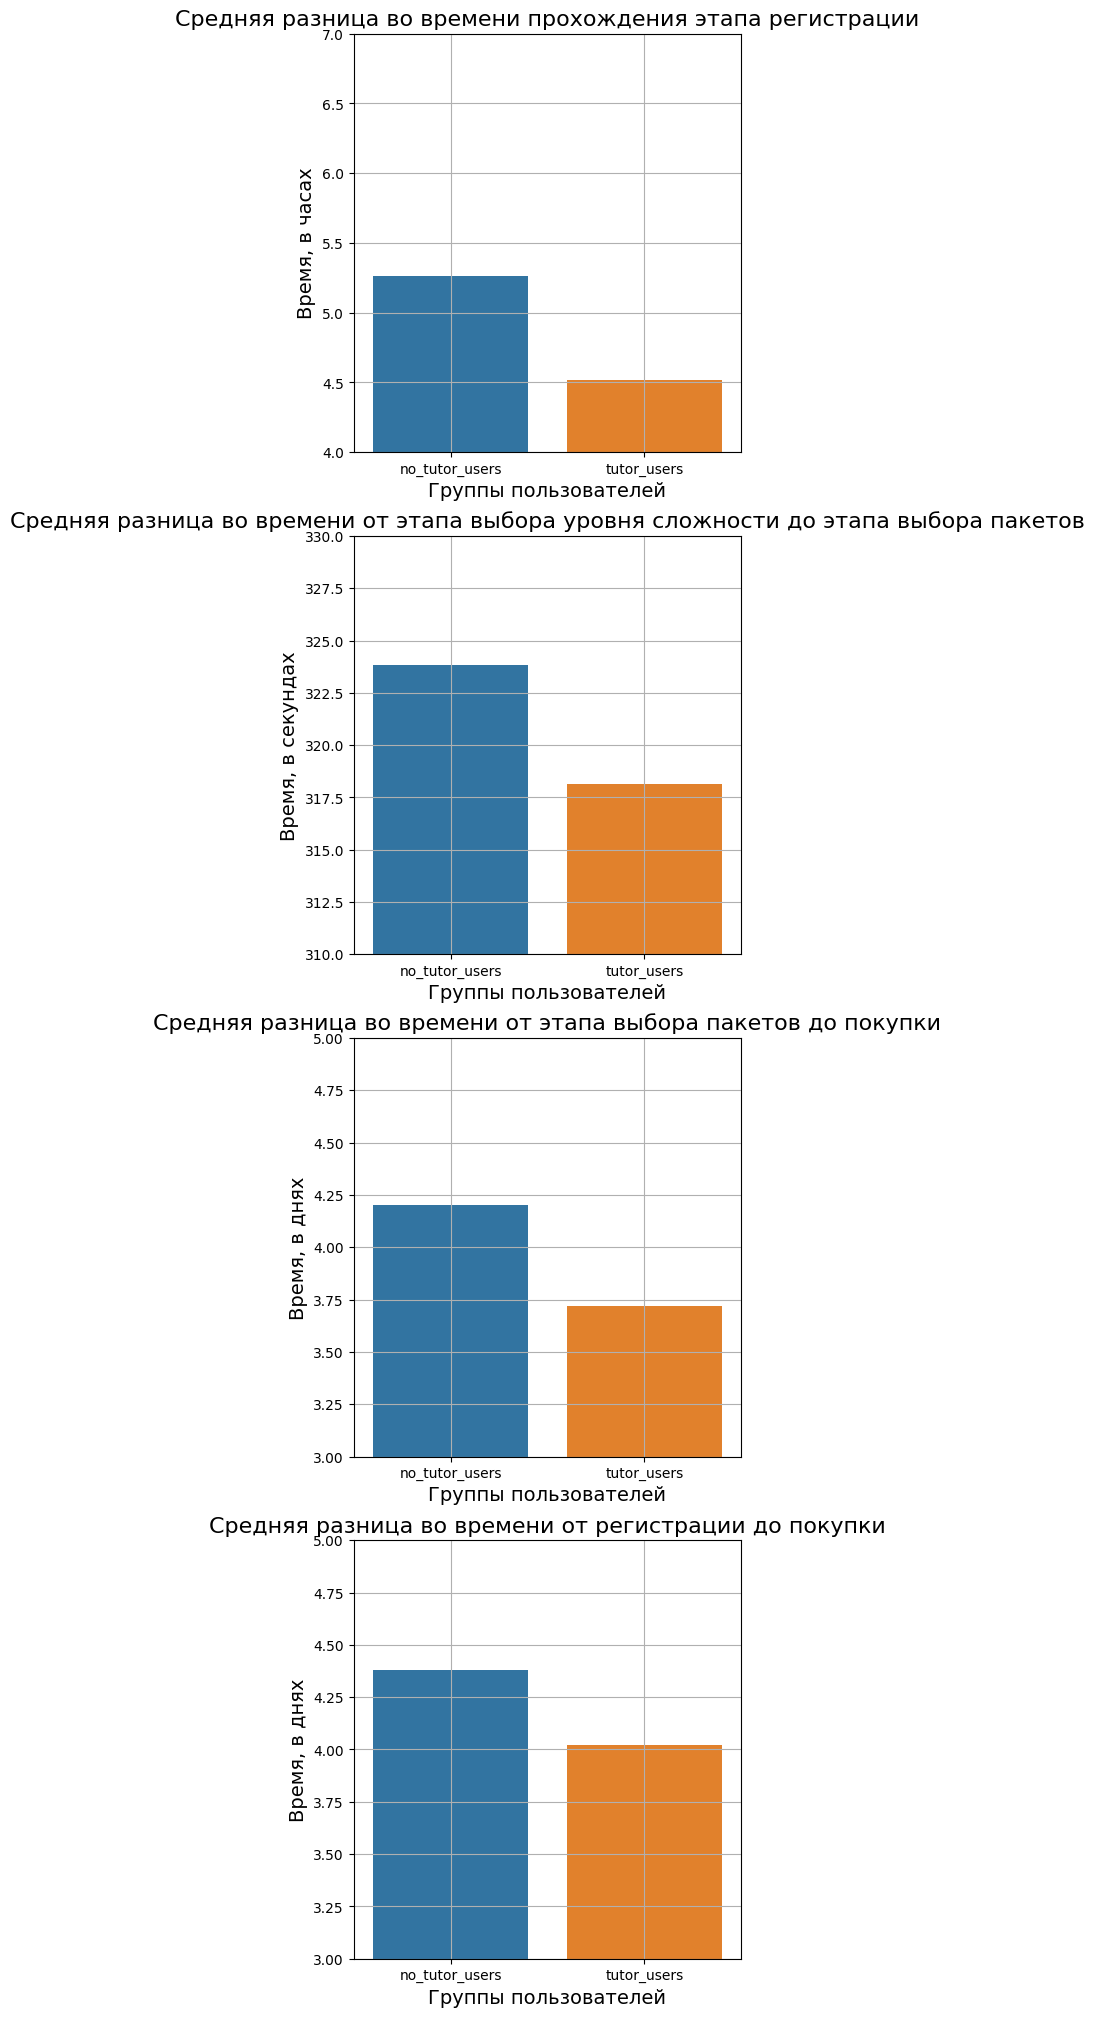

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(5, 25))

barplot1 = sns.barplot(
    data=compare_mean_df,
    x=['no_tutor_users','tutor_users'],
    y='time_registration',
    orient='v',
    ax = axes[0]
    #ci=None
)
barplot1.tick_params(axis='x');
barplot1.set_title('Средняя разница во времени прохождения этапа регистрации', fontsize=16);
barplot1.set_xlabel('Группы пользователей', fontsize=14);
barplot1.set_ylabel('Время, в часах', fontsize=14);
axes[0].set_ylim(4, 7);
barplot1.grid()

barplot2 = sns.barplot(
    data=compare_mean_df,
    x=['no_tutor_users','tutor_users'],
    y='time_from_level_to_pack_choice',

    orient='v',
    ax = axes[1]
    #ci=None,
    #dodge=False
)
barplot2.tick_params(axis='x' );
barplot2.set_title('Средняя разница во времени от этапа выбора уровня сложности до этапа выбора пакетов', fontsize=16);
barplot2.set_xlabel('Группы пользователей', fontsize=14);
barplot2.set_ylabel('Время, в секундах', fontsize=14);
axes[1].set_ylim(310, 330);
barplot2.grid()

barplot3 = sns.barplot(
    data=compare_mean_df,
    x=['no_tutor_users','tutor_users'],
    y='time_from_pack_choice_to_purchase',

    orient='v',
    ax = axes[2]
    #ci=None,

)
barplot3.tick_params(axis='x');
barplot3.set_title('Средняя разница во времени от этапа выбора пакетов до покупки', fontsize=16);
barplot3.set_xlabel('Группы пользователей', fontsize=14);
barplot3.set_ylabel('Время, в днях', fontsize=14);

axes[2].set_ylim(3, 5);
barplot3.grid()


barplot4 = sns.barplot(
    data=compare_mean_df,
    x=['no_tutor_users','tutor_users'],
    y='time_from_reg_to_purchase',

    orient='v',
    ax = axes[3]
    #ci=None,
    #dodge=False
)
barplot4.tick_params(axis='x');
barplot4.set_title('Средняя разница во времени от регистрации до покупки', fontsize=16);
barplot4.set_xlabel('Группы пользователей', fontsize=14);
barplot4.set_ylabel('Время, в днях', fontsize=14);
axes[3].set_ylim(3, 5);
barplot4.grid()


Проделаем то же самое и для таблицы с медианным значением разницы во времени

In [ ]:
import numpy as np
#сформируем копии таблицы и переведем значения в часы, минуты и дни соответственно

compare_median_df=total_diff_df_median_transposed.copy()

compare_median_df['time_registration']=round((compare_median_df['time_registration']/ np.timedelta64(1, "h")),2)
compare_median_df['time_from_level_to_pack_choice']=round((compare_median_df['time_from_level_to_pack_choice']/ np.timedelta64(1, "s")),2)
compare_median_df['time_from_pack_choice_to_purchase']=round((compare_median_df['time_from_pack_choice_to_purchase']/ np.timedelta64(1, "D")),2)
compare_median_df['time_from_reg_to_purchase']=round((compare_median_df['time_from_reg_to_purchase']/ np.timedelta64(1, "D")),2)

display(compare_median_df)

,time_registration,time_from_level_to_pack_choice,time_from_pack_choice_to_purchase,time_from_reg_to_purchase
no_tutor_users,4.93,286.5,4.19,4.48
tutor_users,3.23,298.0,3.51,3.80


В рамках первой гипотезы постройте столбчатую диаграмму, отражающую время прохождения различных этапов для пользователей, которые прошли обучение, и для пользователей, не начинавших обучение.

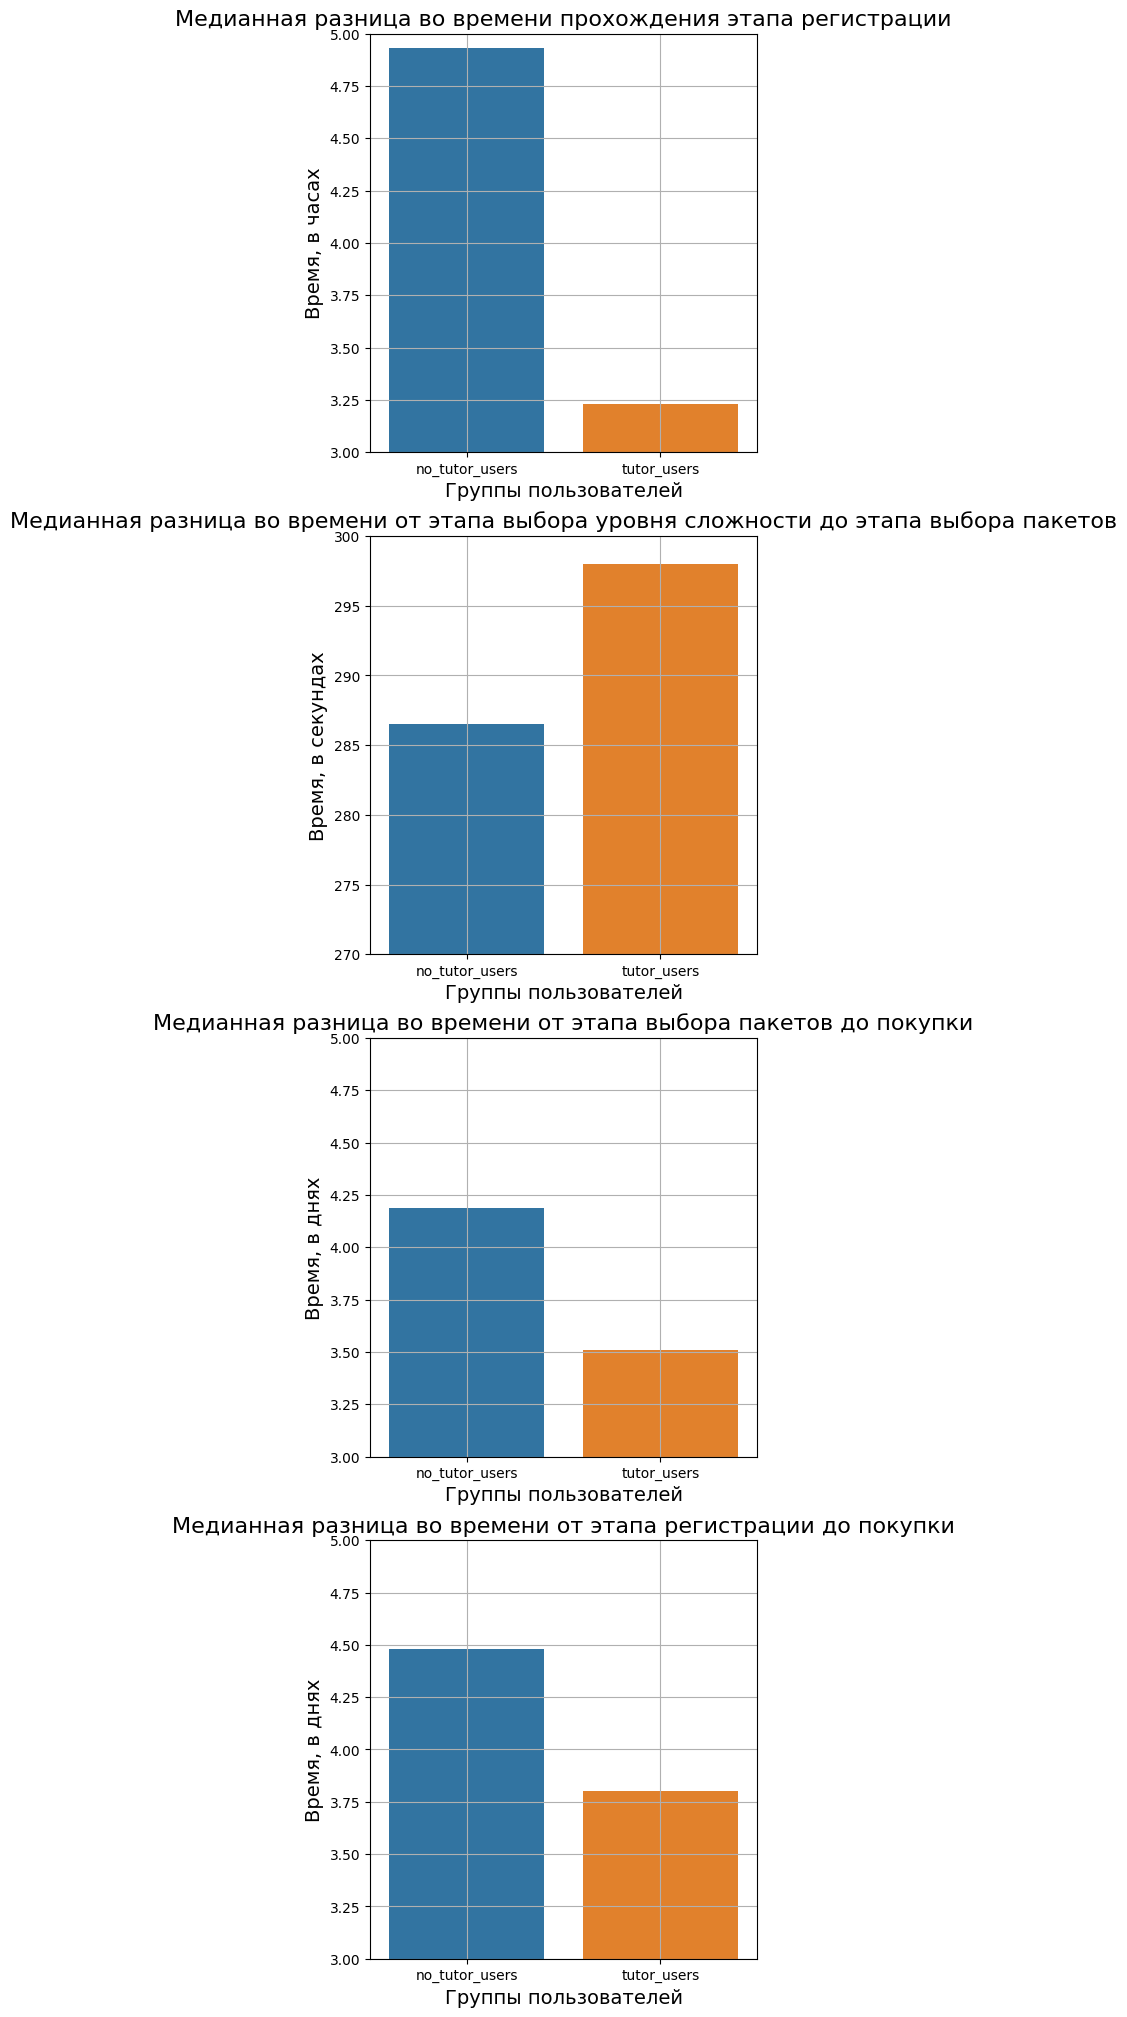

In [ ]:

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(5, 25))

barplot1 = sns.barplot(
    data=compare_median_df,
    x=['no_tutor_users','tutor_users'],
    y='time_registration',
    orient='v',
    ax = axes[0]
    #ci=None
)
barplot1.tick_params(axis='x');
barplot1.set_title('Медианная разница во времени прохождения этапа регистрации', fontsize=16);
barplot1.set_xlabel('Группы пользователей', fontsize=14);
barplot1.set_ylabel('Время, в часах', fontsize=14);
axes[0].set_ylim(3, 5);
barplot1.grid()

barplot2 = sns.barplot(
    data=compare_median_df,
    x=['no_tutor_users','tutor_users'],
    y='time_from_level_to_pack_choice',

    orient='v',
    ax = axes[1]
    #ci=None,
    #dodge=False
)
barplot2.tick_params(axis='x' );
barplot2.set_title('Медианная разница во времени от этапа выбора уровня сложности до этапа выбора пакетов', fontsize=16);
barplot2.set_xlabel('Группы пользователей', fontsize=14);
barplot2.set_ylabel('Время, в секундах', fontsize=14);
axes[1].set_ylim(270, 300);
barplot2.grid()

barplot3 = sns.barplot(
    data=compare_median_df,
    x=['no_tutor_users','tutor_users'],
    y='time_from_pack_choice_to_purchase',

    orient='v',
    ax = axes[2]
    #ci=None,

)
barplot3.tick_params(axis='x');
barplot3.set_title('Медианная разница во времени от этапа выбора пакетов до покупки', fontsize=16);
barplot3.set_xlabel('Группы пользователей', fontsize=14);
barplot3.set_ylabel('Время, в днях', fontsize=14);

axes[2].set_ylim(3, 5);
barplot3.grid()


barplot4 = sns.barplot(
    data=compare_median_df,
    x=['no_tutor_users','tutor_users'],
    y='time_from_reg_to_purchase',

    orient='v',
    ax = axes[3]
    #ci=None,
    #dodge=False
)
barplot4.tick_params(axis='x');
barplot4.set_title('Медианная разница во времени от этапа регистрации до покупки', fontsize=16);
barplot4.set_xlabel('Группы пользователей', fontsize=14);
barplot4.set_ylabel('Время, в днях', fontsize=14);
axes[3].set_ylim(3, 5);
barplot4.grid()

Как видим по диаграммам,среди групп пользователей с обучением и без обучения есть разница в прохождении этапов от выбора уровня сложности вопросов до  выбора пакетов вопросов, а также от выбора пакетов вопросов до покупки. У группы с обучением это время меньше. Давайте узнаем, насколько меньше.

In [ ]:
#По таблице среднего значения

#Разница в абсолютном выражении
total_diff_df_mean['diff_abs']=total_diff_df_mean['no_tutor_users']-total_diff_df_mean['tutor_users']

#Разница в относительном выражении с округлением до целого
total_diff_df_mean['diff_%']=round((total_diff_df_mean['no_tutor_users']-total_diff_df_mean['tutor_users'])*100/total_diff_df_mean['tutor_users'],0)
display(total_diff_df_mean)

,no_tutor_users,tutor_users,diff_abs,diff_%
time_registration,0 days 05:15:33.122448979,0 days 04:31:04.938146341,0 days 00:44:28.184302638,16.0
time_from_level_to_pack_choice,0 days 00:05:23.824324324,0 days 00:05:18.146058732,0 days 00:00:05.678265592,2.0
time_from_pack_choice_to_purchase,4 days 04:49:33.590909090,3 days 17:17:59.641326883,0 days 11:31:33.949582207,13.0
time_from_reg_to_purchase,4 days 09:06:01.909090909,4 days 00:30:03.247408431,0 days 08:35:58.661682478,9.0


Отличается ли время прохождения различных этапов у пользователей, которые прошли обучение, и пользователей, не начинавших обучение?

При сравнении **среднего значения**  можно сделать вывод, что пользователи без обучения проходят все этапы игры за большее время. А именно:


1.   *этап регистрации*:
пользователи без обучения после регистрации переходят к следующему этапу  почти на 44 минуты(на 16%) больше, чем те,кто решился учиться.
2. *этап выбора уровня сложности вопросов*: это самый короткий этап из всех. И соответственно разница на нем небольшая- почти 6 секунд( 2%).
3. *время от этапа выбора пакетов  до покупки платных вопросов*:
пользователи без обучения выбирают пакеты вопросов дольше почти на 11,5 ч.(на 13%) Тут, действительно,им приходится сложнее, так как
4. *общее время от регистрации до покупки*:
у пользователей без обучения весь путь от регистрации до покупки занимает на
 8,5 часов(на 9%) больше, чем у тех, кто прошел обучение.

In [ ]:
#По таблице медианного значения

#Разница в абсолютном выражении
total_diff_df_median_['diff_abs']=total_diff_df_median_['no_tutor_users']-total_diff_df_median_['tutor_users']

#Разница в относительном выражении с округлением до целого
total_diff_df_median_['diff_%']=round((total_diff_df_median_['no_tutor_users']-total_diff_df_median_['tutor_users'])*100/total_diff_df_median_['tutor_users'],0)

display(total_diff_df_median_)

,no_tutor_users,tutor_users,diff_abs,diff_%
time_registration,0 days 04:56:05.500000,0 days 03:13:48,0 days 01:42:17.500000,53.0
time_from_level_to_pack_choice,0 days 00:04:46.500000,0 days 00:04:58,-1 days +23:59:48.500000,-4.0
time_from_pack_choice_to_purchase,4 days 04:38:42,3 days 12:15:56,0 days 16:22:46,19.0
time_from_reg_to_purchase,4 days 11:29:09,3 days 19:04:59,0 days 16:24:10,18.0


*Пояснения к значению абсолютной разницы во времени прохождения этапа выбора сложности вопросов: -1 days +23:59:48.500000 - это означает разницу почти в 2 секунды.*

>
Отличается ли время прохождения различных этапов у пользователей, которые прошли обучение, и пользователей, не начинавших обучение?

При сравнении **медианного значения** выводы следующие:


1.   *этап регистрации:* тут  почти 2 часа разница - пользователи без обучения тратят почти на 50% больше, чем те, кто обучался. Возможно, пользователям без обучения нужно дополнительное время, чтобы подумать, на какой из дальнейших этапов перейти-стоит проходить обучение или нет. Выбирая не обучаться, они идут дальше.
2.   *этап выбора уровня сложности вопросов:* тут интересно- пользователи без обучения на 2 секунды(на 4%) раньше переходят к следующему этапу, чем пользователи,  прошедшие обучение.  Возможно, это связано с тем, что после обучения приходится чуть дольше думать над тем, справятся ли они с более сложными вопросами или нет. Нужно провести дополнительное исследование о том, какой уровень сложности вопросов выбирают пользователи с обучением и без. Возможно, потому, что медианная разница ближе к действительности, так как не учитывает большие разбросы в разнице во времени.
3. *время от этапа выбора пакетов до покупки платных вопросов*: пользователи без обучения выбирают пакеты вопросов дольше, чем обученные пользователи, на 16 ч.(на 19%) Тут, действительно,им приходится сложнее, так как не было обучения.
4. *общее время от регистрации до покупки:* у пользователей без обучения весь путь от регистрации до покупки занимает больше, чем на 16ч(на 18%) больше, чем у тех, кто прошел обучение.



## Общие выводы по гипотезе № 1 :

---


1. Очень много времени занимает регистрация пользователей- от 3 часов до 5 часов среди двух групп пользователей.
25% и 75%-квартиль составляют: 2ч и 8,5 часов соответственно - у группы без обучения и 1ч и 6,5 часов соответственно - у группы с обучением.  
Минимальное время, потраченное на регистрацию, составляет 34 секунды, максимальное время- более 18 часов.  
Учитывая эти данные, нужно  проанализировать обязательные и необязательные вопросы и способы заполнения ответов, постараться сократить время регистрации.
2. Пользователи, успешно окончившие обучение, более охотно переходят на этап выбора уровня сложности вопросов(50% у обучившихся против 1% у необученных). После этого этапа им легче выбрать пакет вопросов и осуществить саму покупку.
3. Можно утверждать, что обучение способствует вовлеченности пользователей в игру и повышению интереса к ней. Обученные пользователям проходят все этапы быстрее и увереннее. Что в конечном итоге  приводит к более быстрой покупке платных вопросов( на 8ч по среднему значению и на 16ч по медианному),  а значит большему увеличению прибыли компании.






---
##                              Гипотеза  № 2


---
Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.

---
**Задача**

Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь.





1. Сначала поделим всех пользователей на группы по количеству завершенных обучений, включая не обучившихся.
2. Потом сравним данные групп по оплате.

In [ ]:
#общая таблица с событиями и оплаты уже есть- total_events_df

#создадим в ней отдельный столбец с id завершенного обучения, по котрому можно посчитать количество таких обучений
total_events_df['tutorial_finish_id']= total_events_df[total_events_df['event_type']=='tutorial_finish']['tutorial_id']

#сгруппируем данные по пользователям и посчитаем количество завершеных обучений и оплат
hipotese2_df=total_events_df.groupby('user_id')['tutorial_finish_id', 'purchase_id'].count()

#tutor_df_hip3=pd.DataFrame(tutor_df_hip2)
#отобразим получившиеся данные
display(hipotese2_df)

<ipython-input-40-d17df399f2b8>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  hipotese2_df=total_events_df.groupby('user_id')['tutorial_finish_id', 'purchase_id'].count()


,tutorial_finish_id,purchase_id
user_id,,
27832,0,0
27833,1,0
27834,1,0
27835,1,0
27836,1,0
...,...,...
47753,1,0
47754,0,0
47755,1,0


In [ ]:
#выведем количество значений по столбцам
display(hipotese2_df.value_counts())

tutorial_finish_id  purchase_id
0                   0              9523
1                   0              6872
                    1              1143
2                   0              1139
3                   0               301
2                   1               182
4                   0               159
0                   1               153
5                   0                98
6                   0                86
7                   0                82
8                   0                48
3                   1                44
4                   1                19
5                   1                19
9                   0                18
6                   1                15
7                   1                15
8                   1                 6
9                   1                 4
dtype: int64

  Оказалось, что пользователи поделились на 10 групп, из них группа 0 - это не окончившие ни разу обучение, а 10я - это ученики, которые прошли обучение 9 раз.

  Давайте посмотрим, сколько в каждой группе пользователей оплатили покупку платных вопросов, а сколько-нет.

In [ ]:
#создадим на основе полученных данных словарь, где ключами будут пара значений в столбцах, а значениями-количество пользователей
dict1=dict(hipotese2_df.value_counts())

#посмотрим на словарь
display(dict1)

{(0, 0): 9523,
 (1, 0): 6872,
 (1, 1): 1143,
 (2, 0): 1139,
 (3, 0): 301,
 (2, 1): 182,
 (4, 0): 159,
 (0, 1): 153,
 (5, 0): 98,
 (6, 0): 86,
 (7, 0): 82,
 (8, 0): 48,
 (3, 1): 44,
 (4, 1): 19,
 (5, 1): 19,
 (9, 0): 18,
 (6, 1): 15,
 (7, 1): 15,
 (8, 1): 6,
 (9, 1): 4}

In [ ]:
#Рассчитаем для каждой группы пользователей конверсию в оплату
tut0=dict1[(0,1)]/(dict1[(0,1)]+dict1[(0,0)])
tut1=dict1[(1,1)]/(dict1[(1,1)]+dict1[(1,0)])
tut2=dict1[(2,1)]/(dict1[(2,1)]+dict1[(2,0)])
tut3=dict1[(3,1)]/(dict1[(3,1)]+dict1[(3,0)])
tut4=dict1[(4,1)]/(dict1[(4,1)]+dict1[(4,0)])
tut5=dict1[(5,1)]/(dict1[(5,1)]+dict1[(5,0)])
tut6=dict1[(6,1)]/(dict1[(6,1)]+dict1[(6,0)])
tut7=dict1[(7,1)]/(dict1[(7,1)]+dict1[(7,0)])
tut8=dict1[(8,1)]/(dict1[(8,1)]+dict1[(8,0)])
tut9=dict1[(9,1)]/(dict1[(9,1)]+dict1[(9,0)])

print('Процент оплаты в группе пользователей в зависимости от количества завершенных обучений(от 0 до 9):','\n')
print('0 обучений: {:.2%}'. format(tut0),
      '1 обучение: {:.2%}'.format(tut1),
      '2 обучения: {:.2%}'.format(tut2),
      '3 обучения: {:.2%}'.format(tut3),
      '4 обучения: {:.2%}'.format(tut4),
      '5 обучений: {:.2%}'.format(tut5),
      '6 обучений: {:.2%}'.format(tut6),
      '7 обучений: {:.2%}'.format(tut7),
      '8 обучений: {:.2%}'.format(tut8),
      '9 обучений: {:.2%}'.format(tut9),
            sep='\n')

Процент оплаты в группе пользователей в зависимости от количества завершенных обучений(от 0 до 9): 

0 обучений: 1.58%
1 обучение: 14.26%
2 обучения: 13.78%
3 обучения: 12.75%
4 обучения: 10.67%
5 обучений: 16.24%
6 обучений: 14.85%
7 обучений: 15.46%
8 обучений: 11.11%
9 обучений: 18.18%


In [ ]:
#можно представить ответ проще в виде словаря, ключи которого- количество обучений, значения- процент оплат
import pprint as pp
dict_tut=dict()
for i in range(0, 10):

  dict_tut.setdefault(i, round(dict1[(i,1)]*100/(dict1[(i,1)]+dict1[(i,0)]),2))

pp.pprint(dict_tut)

{0: 1.58,
 1: 14.26,
 2: 13.78,
 3: 12.75,
 4: 10.67,
 5: 16.24,
 6: 14.85,
 7: 15.46,
 8: 11.11,
 9: 18.18}


Как видим, среди пользователей, у кого нет обучения, - всего 1.58%, кто оплатил платные вопросы. К этому выводу мы пришли, решая и задачу первой гипотезы.

In [ ]:
#ппроанализируем остальные данные. Для этого превратим полученный словарь в структуру данных Series
dict_tut_s = pd.Series(list(dict_tut.values()),index=dict_tut.keys())

#посмотрим на данные по обучившимся
display(dict_tut_s[1:].describe())

count     9.000000
mean     14.144444
std       2.405094
min      10.670000
25%      12.750000
50%      14.260000
75%      15.460000
max      18.180000
dtype: float64

По остальным группам пользователей, обучившихся от 1 до 9 раз, наблюдается равномерное распределение. Среднее значение и медиана почти равны. Значения колеблются в небольшом диапазоне от 10.67% до 18.18%.

В качестве визуализации ответа на вопрос 2 гипотезы построим столбчатую диаграмму, отражающую долю оплат для группы пользователей.

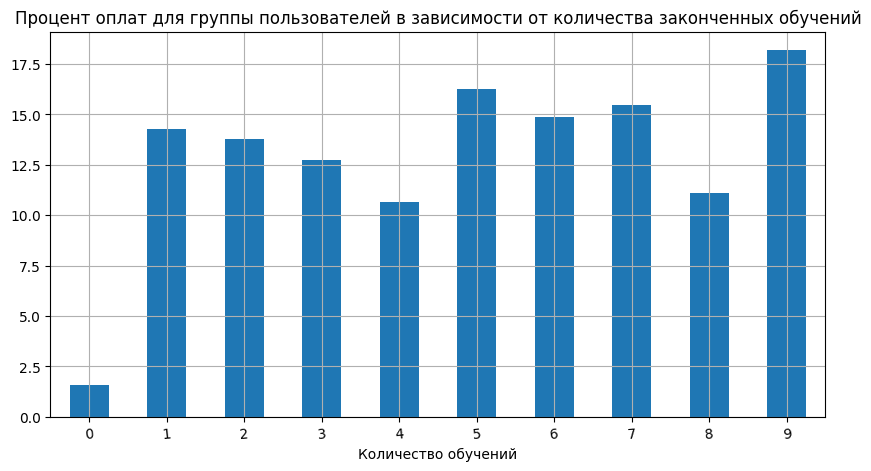

In [ ]:
#построим столбчатую диаграмму
import matplotlib.pyplot as plt
dict_tut_s.plot(
	    kind='bar',
      xlabel="Количество обучений",
      fontsize=10,
      rot=5,
	    figsize=(10, 5),
	    title='Процент оплат для группы пользователей в зависимости от количества законченных обучений',
      grid = True,
	    lw=3
	);


## Общие выводы по гипотезе № 2


---
1. По полученным данным и графику еще раз доказано, что обучение само по себе сильно влияет на оплату. Всего 1.58% от необучившихся приобрели платный пакет вопросов.

2. А вот количество обучений и то, каким этапом шло обучение, не влияет на вероятность оплаты, так как значения процента оплаты от всех пользователей по группам не имеют скачков, находятся в небольшом диапазоне: примерно от 10% до 20%.

3. Это означает, что зависимости между вероятностью оплаты вопросов и количеством обучений, которые завершал пользователь, нет.

4. Успешное обучение само по себе влияет на оплату и не имеет значения то, сколько раз пользователь обучался.


#            Гипотеза № 3

---
Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?

---

**Задача**
Определить, насколько прозрачен процесс взаимодействия с игрой. А именно выяснить, как часто пользователи начинают обучение после выбора уровня сложности.


1. Сначала отберем пользователей, которые дошли до этапа выбора уровня сложности вопросов, чтобы не загромождать лишними данными наши таблицы.
2. Объединим для каждого пользователя события, связанные с обучением и этапом выбора уровня сложности вопросов в один список, отображающий последовательность между этими этапами.
3. Рассчитаем частоту списков, где пользователи начинают обучение после выбора уровня сложности.

In [ ]:
#посмотрим на готовую таблицу events с событиями для пользователей, зарегистрированных в 2018г.
events.head()
events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66959 entries, 51405 to 118364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   event_id        66959 non-null  int64  
 1   event_type      66959 non-null  object 
 2   selected_level  8342 non-null   object 
 3   start_time      66959 non-null  object 
 4   tutorial_id     32954 non-null  float64
 5   user_id         66959 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 3.6+ MB


In [ ]:
#Как видно, тип данных столбца start_time нужно привести к типу datetime
events['start_time']=pd.to_datetime(events['start_time'])

#проверим
display(events.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66959 entries, 51405 to 118364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   event_id        66959 non-null  int64         
 1   event_type      66959 non-null  object        
 2   selected_level  8342 non-null   object        
 3   start_time      66959 non-null  datetime64[ns]
 4   tutorial_id     32954 non-null  float64       
 5   user_id         66959 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 3.6+ MB


None

In [ ]:
#отберем пользователей, которые дошли до этапа выбора уровня сложности вопросов.
mask_level= (events['event_type']=='level_choice')

#запомним их в список users_lock и посмотрим на их дальнейший путь по этапам игры
users_lock=list(events[mask_level]['user_id'].unique())

#посмотрим на количество таких пользователей в списке
display(len(users_lock))


8342

In [ ]:
#отсортируем таблицу событий для пользователей, зарегистрированных в 2018г., исключив всех, кто не дошел до этапа выбора уровня сложности.
maska1=(events['user_id'].isin(users_lock))

#в рамках данной гипотезы выберем только интересующие нас события tutorial_start и level_choice
maska2=(events['event_type']=='tutorial_start')
maska3=(events['event_type']=='level_choice')

#сформируем таблицу level_df на основе таблицы events с учетом фильтров, отсортируем значения по пользователю и по времени наступления его событий
level_df=events[maska1&(maska2|maska3)].sort_values(by=['user_id','start_time'])

#посмотрим на значения таблицы level_df
display(level_df.head())




,event_id,event_type,selected_level,start_time,tutorial_id,user_id
51413,80316,tutorial_start,NaN,2018-01-01 15:00:51,31506.0,27835
51424,80327,level_choice,medium,2018-01-01 20:37:22,NaN,27835
51420,80323,tutorial_start,NaN,2018-01-01 19:11:36,31509.0,27839
51428,80331,level_choice,hard,2018-01-01 22:37:50,NaN,27839
51434,80337,tutorial_start,NaN,2018-01-02 02:07:07,31511.0,27840


In [ ]:
#Сгруппируем события по пользователям и запишем их последовательность в список.  Запишем результат в таблицу group_level_df.
group_level_df = level_df.groupby(["user_id"])["event_type"].apply(list).reset_index()

#посмотрим на первые записи таблицы
group_level_df.head()

,user_id,event_type
0,27835,"[tutorial_start, level_choice]"
1,27839,"[tutorial_start, level_choice]"
2,27840,"[tutorial_start, level_choice]"
3,27842,"[tutorial_start, level_choice, tutorial_start,..."
4,27843,"[tutorial_start, level_choice]"


In [ ]:
#Во 2 гипотезе нужно проверить, как часто пользователи начинают обучение после выбора уровня сложности.
#Поэтому этапы обучения, которые идут перед этапом выбора уровня сложности вопросов, можно удалить

#для этого напишем небольшую функцию convert_, которая в списке с этапами будет отсекать все tutorial_start, если они идут до level_choice
def convert_(a):
  for i in range(len(a)):
    if a[i]=='level_choice':
      return(a[i:])

#создадим новый столбец в таблице group_level_df с измененными  последовательностями событий
group_level_df['new_event_type']= group_level_df['event_type'].apply(convert_)

#посмотрим, что получилось
display(group_level_df['new_event_type'])



0                                       [level_choice]
1                                       [level_choice]
2                                       [level_choice]
3       [level_choice, tutorial_start, tutorial_start]
4                                       [level_choice]
                             ...                      
8337                                    [level_choice]
8338                                    [level_choice]
8339                                    [level_choice]
8340                                    [level_choice]
8341                                    [level_choice]
Name: new_event_type, Length: 8342, dtype: object

In [ ]:
#преобразуем список событий в строку, значения запишем в новый столбец event_path
group_level_df['event_path']= group_level_df['new_event_type'].apply(lambda x: " > ".join(x))

In [ ]:
#сгруппируем таблицу по столбцу event_path и узнаем число пользователей в группе, отсортируем по убыванию их значений

level_tut_path_df = (group_level_df.groupby(["event_path"])["user_id"].nunique().sort_values(ascending=False)).reset_index()
level_tut_path_df.columns=['event_path','count']

#посмотрим на результат
display(level_tut_path_df )


,event_path,count
0,level_choice,6956
1,level_choice > tutorial_start,819
2,level_choice > tutorial_start > tutorial_start,229
3,level_choice > tutorial_start > tutorial_start...,116
4,level_choice > tutorial_start > tutorial_start...,77
5,level_choice > tutorial_start > tutorial_start...,57
6,level_choice > tutorial_start > tutorial_start...,51
7,level_choice > tutorial_start > tutorial_start...,28
8,level_choice > tutorial_start > tutorial_start...,9


В результате получилось 8 групп:
1 группа - только с этапом выбора уровня сложности вопросов без обучения после него и 7 групп, где потребовалось обучение.
7 групп с обучением отличаются количеством обучений: от 1 до 8 раз.
Индексы итогового датафрейма совпали с количеством обучений:
1- это 1 обучение после этапа level_choice,
2- это 2 обучения и т.д. В последней- 8 группе пользователи начинали обучение 8 раз.


По таблице можно заметить, что самая большая группа(6956 человек) - это те, кто после выбора уровня сложности вопросов ни разу не начал обучение. Напомним, что всего пользователей, которые дошли до выбора уровня сложности вопросов- 8342 человека. Получается, что 83,4% игроков все было понятно.

На 2м месте- 819 человек (9,8%)- начали 1 обучение после выбора уровня сложности вопросов.

На 3м месте -229 пользователей(2,7%)- те, кому понадобилось 2 раза начать обучение после выбора уровня сложности вопросов.

На последнем месте 9 игроков, кому пришлось проходить обучение еще 8 раз после этапа до выбора уровня сложности вопросов. К счастью разработчиков, это всего по 0,1% из 8432 игроков.


# Общие выводы по гипотезе № 3

---
Как часто пользователи начинают обучение после того, как выбрали уровень сложности тренировок?
1. На основе полученных данных можно сделать вывод, что значительная часть (почти 83%) игроков не нуждается в обучении после того, как прошли этап выбора уровня сложности вопросов.

2. Группа, кому пришлось пройти обучение 1 раз после выбора уровня сложности вопросов, составляет почти 10%.

3. Остальных, кто столкнулся  с большими трудностями и начал обучение после выбора уровня сложности вопросов более 1 раза, можно объединить  в одну группу из-за незначительности подгрупп(от 0.1% до 2.7%).  

Это хорошие показатели для приложения, обеспечивающие прозрачность процесса взаимодействия с игрой. Для полного анализа рекомендуется исследовать эти 10%, кому все-таки пришлось инициировать обучение после того, как они прошли этап выбора уровня сложности вопросов. Разработчикам нужно выяснить, почему, и при необходимости внести исправления в работу приложения. Все это скажется положительным образом на поддержании  интереса к игре со стороны пользователей и их желании дойти до конца и осуществить покупку платных вопросов.: